<a href="https://colab.research.google.com/github/Kosuke-K-21/crypto_prophets/blob/main/Prediction_to_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -qqq install darts optuna yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.1 MB/s eta 0

In [ ]:
import numpy as np
import pandas as pd
import darts
import optuna

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') 
plt.rcParams['figure.figsize'] = [12, 9] 

from pandas_datareader import data as pdr
import yfinance as yfin

# Obtaining Datasets

In [ ]:
import datetime

today = datetime.date.today()
yesterday = today - datetime.timedelta(days=1)
yesterday_5yearsback = yesterday - datetime.timedelta(days=365*5)

In [ ]:
yfin.pdr_override()

tickers = ['BTC', 'ETH', 'BNB', 'XRP', 'HEX', 'ADA', 'DOGE', 'SOL']

df_ind = pd.date_range(start=yesterday_5yearsback, periods=365*5, freq='D')
df = pd.DataFrame(columns=tickers, index=df_ind)

for ticker in tickers:
    data = pdr.get_data_yahoo(ticker+'-USD', start=yesterday_5yearsback, end=yesterday)
    df[ticker] = data['Adj Close']

df = df.dropna()
df.reset_index(inplace=True)
df['date'] = pd.to_datetime(df['index'])
df.drop('index', axis=1, inplace=True)

df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-6-3d4152b0ef16>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['index'])
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,BTC,ETH,BNB,XRP,HEX,ADA,DOGE,SOL,date
0,6865.493164,158.412445,13.737724,0.187464,0.000425,0.033215,0.001968,0.951054,2020-04-10
1,6859.083008,158.216019,13.804288,0.188063,0.000496,0.033354,0.001990,0.776819,2020-04-11
2,6971.091797,161.142426,14.375111,0.190135,0.000572,0.033806,0.001990,0.882507,2020-04-12
3,6845.037598,156.279556,15.034427,0.187732,0.000506,0.033107,0.001959,0.777832,2020-04-13
4,6842.427734,157.596390,15.525076,0.185335,0.000549,0.032974,0.001964,0.661925,2020-04-14


In [ ]:
df.to_csv('original.csv')

# Visualizing the data

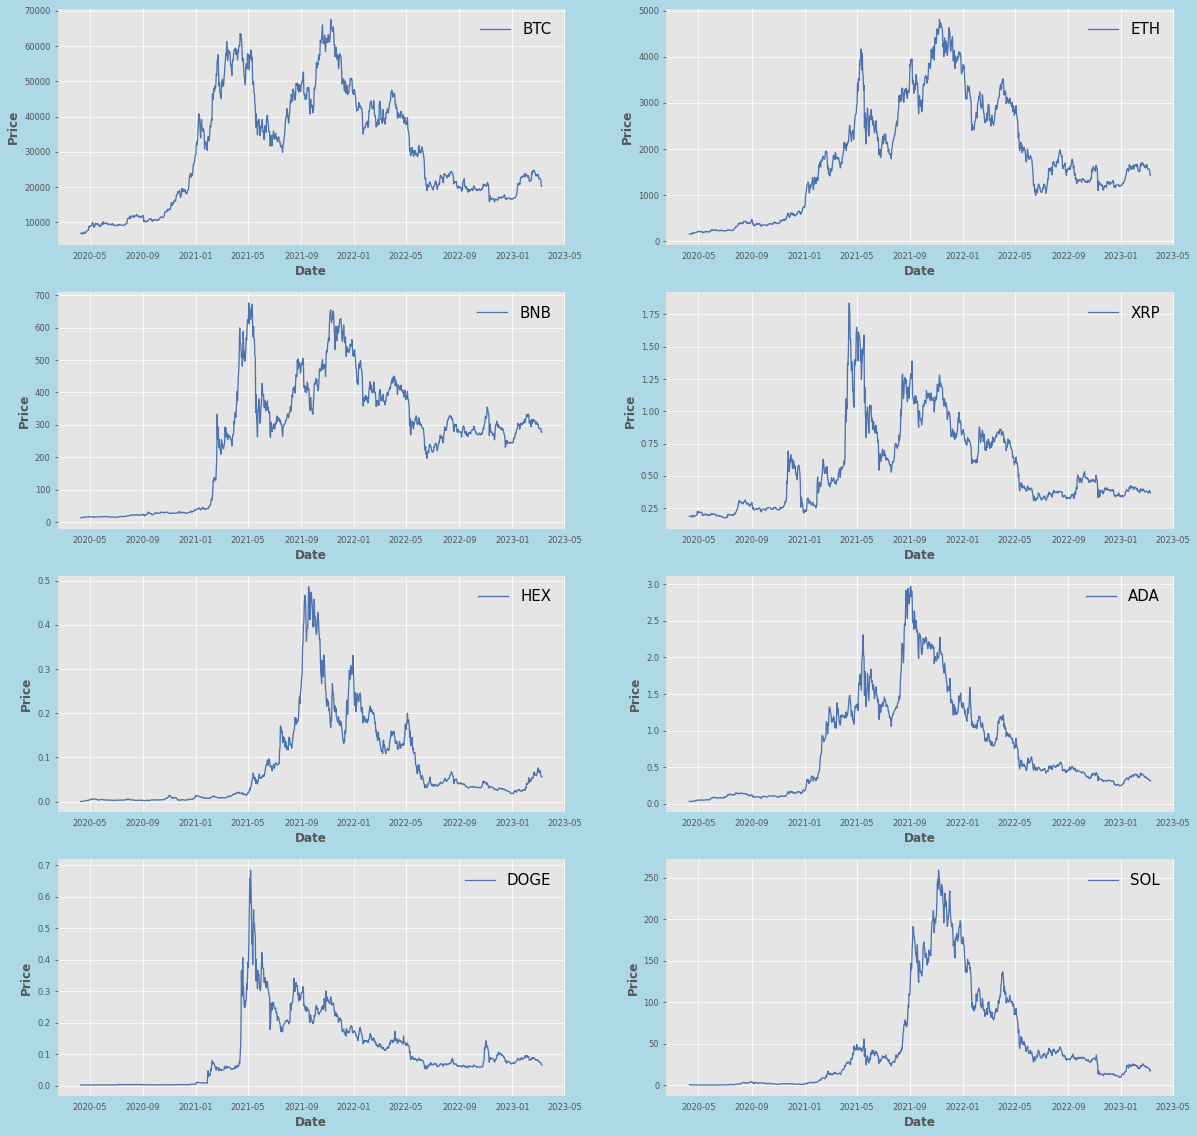

In [ ]:
fig = plt.figure(figsize = (20,20), facecolor='lightblue')

for i, ticker in enumerate(tickers): 
  ax = fig.add_subplot(4, 2, i+1)
  ax.plot(df['date'], df[ticker], color='b', label=ticker)

  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  ax.legend(loc = 'upper right', prop={'size': 15}) 
  
sns.set()

plt.show()
plt.close()

# Preprocessing the datasets
Dataframe is converted to Timeseries object for Darts Library<br>
Models predict log difference of price, not price directly

In [ ]:
from darts import TimeSeries as ts
from darts.utils.model_selection import train_test_split

series = ts.from_dataframe(df, "date", tickers)

# calculate log difference
series_ld = series.map(np.log).diff()


val_length = 30

train, val = train_test_split(series_ld, test_size=30)

# Creating model, Prediction, and Evaluation

We predict only a price of Bitcoin for this demonstration purpose.

## ARIMA

In [ ]:
from darts.models.forecasting import arima
from darts.metrics import rmse

for i, ticker in enumerate(tickers):
  model_arima = arima.ARIMA()

  potential_params = {
      'p': [0, 1, 2, 4, 6, 8, 10],
      'd' : range(0, 3),
      'q' : range(0, 3)
  }


  best_model_arima, best_params, best_score= model_arima.gridsearch(
      potential_params, 
      series=train[ticker], 
      val_series = val[ticker],
      metric = rmse
  )

  model_arima_bestparams = arima.ARIMA(**best_params)

  model_arima_bestparams.fit(series_ld[ticker])

  prediction_arima  = model_arima_bestparams.predict(len(val), num_samples=1000)

  prediction_arima_val = prediction_arima.map(lambda x: np.exp(np.add.accumulate(x)) * df.iat[-1, i])

  if i == 0:
    df_arima = prediction_arima_val.quantile_timeseries().pd_dataframe()
  else:
    df_arima = pd.merge(df_arima, prediction_arima_val.quantile_timeseries().pd_dataframe(), left_index=True, right_index=True)

df_arima.head()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarima

component,BTC_0.5,ETH_0.5,BNB_0.5,XRP_0.5,HEX_0.5,ADA_0.5,DOGE_0.5,SOL_0.5
date,,,,,,,,
2023-03-11,19431.999910,1396.882443,274.298846,0.371816,0.055353,0.321110,0.063850,17.567500
2023-03-12,18816.158809,1350.579444,270.936120,0.367986,0.054972,0.325696,0.060759,16.875791
2023-03-13,18614.723338,1304.710283,268.860032,0.365078,0.055499,0.334552,0.059274,16.521404
2023-03-14,18148.363551,1268.068226,265.003251,0.361530,0.055350,0.340246,0.057300,16.171227
2023-03-15,18053.792272,1224.505404,263.621100,0.362335,0.055436,0.350525,0.055756,15.956596


In [ ]:
df_arima.to_csv('arima.csv')

## Prophet

In [ ]:
from darts.models.forecasting import prophet_model

model_prop = prophet_model.Prophet()

for i, ticker in enumerate(tickers):
  model_prop.fit(series_ld[ticker])

  prediction_prop  = model_prop.predict(val_length, num_samples=1000)

  prediction_prop_val = prediction_prop.map(lambda x: np.exp(np.add.accumulate(x)) * df.iat[-1, i])

  if i == 0:
    df_prop = prediction_prop_val.quantile_timeseries().pd_dataframe()
  else:
    df_prop = pd.merge(df_prop, prediction_prop_val.quantile_timeseries().pd_dataframe(), left_index=True, right_index=True)

df_prop.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy2hpciz0/mqlk5tgt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy2hpciz0/vj0c0dq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44290', 'data', 'file=/tmp/tmpy2hpciz0/mqlk5tgt.json', 'init=/tmp/tmpy2hpciz0/vj0c0dq5.json', 'output', 'file=/tmp/tmpy2hpciz0/prophet_modelpyjvsvlp/prophet_model-20230312073520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy2h

component,BTC_0.5,ETH_0.5,BNB_0.5,XRP_0.5,HEX_0.5,ADA_0.5,DOGE_0.5,SOL_0.5
date,,,,,,,,
2023-03-11,20137.190364,1428.887045,275.429477,0.372863,0.057166,0.316352,0.065953,18.100304
2023-03-12,20061.515738,1431.079926,272.782460,0.369422,0.056655,0.312989,0.065521,18.007677
2023-03-13,20049.964503,1427.487852,271.504353,0.371279,0.056789,0.310656,0.064356,17.860859
2023-03-14,20050.217276,1425.688271,270.991252,0.371418,0.057493,0.309878,0.064508,17.751806
2023-03-15,20207.124731,1435.595455,270.748862,0.371931,0.058904,0.312514,0.064545,17.498738


In [ ]:
df_prop.to_csv('prophet.csv')

## Kalman Filter

In [ ]:
from darts.models.forecasting import kalman_forecaster

model_kf = kalman_forecaster.KalmanForecaster()

for i, ticker in enumerate(tickers):
  model_kf.fit(series_ld[ticker])

  prediction_kf  = model_kf.predict(val_length, num_samples=1000)

  prediction_kf_val = prediction_kf.map(lambda x: np.exp(np.add.accumulate(x)) * df.iat[-1, i])

  if i == 0:
    df_kf = prediction_kf_val.quantile_timeseries().pd_dataframe()
  else:
    df_kf = pd.merge(df_kf, prediction_kf_val.quantile_timeseries().pd_dataframe(), left_index=True, right_index=True)

df_kf.head()

component,BTC_0.5,ETH_0.5,BNB_0.5,XRP_0.5,HEX_0.5,ADA_0.5,DOGE_0.5,SOL_0.5
date,,,,,,,,
2023-03-11,20165.933709,1427.230980,277.089641,0.369998,0.055935,0.315150,0.065904,18.273199
2023-03-12,20174.964512,1432.338704,274.789306,0.370357,0.055783,0.314801,0.065669,18.230721
2023-03-13,20173.605150,1421.390859,275.568622,0.370894,0.055447,0.315207,0.065724,18.107112
2023-03-14,20156.561014,1419.295722,275.209460,0.371101,0.054917,0.315962,0.065941,18.082327
2023-03-15,20143.376589,1422.038759,275.638936,0.369301,0.055261,0.315059,0.066028,18.042470


In [ ]:
df_kf.to_csv('kalman.csv')

## N-BEATS

In [ ]:
from darts.models.forecasting import nbeats
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanSquaredError

In [ ]:
for i, ticker in enumerate(tickers):
  scaler = Scaler()
  series_ld_scaled = scaler.fit_transform(series_ld[ticker]).astype(np.float32)

  # train_scaled, val_scaled = series_ld_scaled[:-val_length], series_ld_scaled[-val_length:]

  # A TorchMetric or val_loss can be used as the monitor
  torch_metrics = MeanSquaredError()

  # Early stop callback
  nbeats_stopper = EarlyStopping(
      monitor="train_MeanSquaredError",  # "val_loss",
      patience=50,
      min_delta=0.05,
      mode='min',
  )

  nbeats_pl_trainer_kwargs = {"callbacks": [nbeats_stopper]}

  # Create the model
  model_nbeats = nbeats.NBEATSModel(
      input_chunk_length=60,
      output_chunk_length=30,
      generic_architecture=True,
      num_stacks=10,
      num_blocks=1,
      num_layers=4,
      layer_widths=512,
      dropout=0.2,
      n_epochs=500,
      nr_epochs_val_period=1,
      batch_size=256,
      torch_metrics=torch_metrics,
      pl_trainer_kwargs=nbeats_pl_trainer_kwargs,
      random_state=42,
      model_name="nbeats_run"
  )

  model_nbeats.fit(series_ld_scaled, verbose=True)

  pred = model_nbeats.predict(n=30, num_samples=1000)

  # scale back:
  prediction_nbeats = scaler.inverse_transform(pred)
  # val = scaler.inverse_transform(val_scaled)

  prediction_nbeats_val = prediction_nbeats.map(lambda x: np.exp(np.add.accumulate(x)) * df.iat[-1, i])

  if i == 0:
    df_nbeats = prediction_nbeats_val.quantile_timeseries().pd_dataframe()
  else:
    df_nbeats = pd.merge(df_nbeats, prediction_nbeats_val.quantile_timeseries().pd_dataframe(), left_index=True, right_index=True)

df_nbeats.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.2 M 
---------------------------------------------------
8.2 M     Trainable params
2.9 K     Non-trainable params
8.2 M     

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.2 M 
---------------------------------------------------
8.2 M     Trainable params
2.9 K     Non-trainable params
8.2 M     

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.2 M 
---------------------------------------------------
8.2 M     Trainable params
2.9 K     Non-trainable params
8.2 M     

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.2 M 
---------------------------------------------------
8.2 M     Trainable params
2.9 K     Non-trainable params
8.2 M     

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.2 M 
---------------------------------------------------
8.2 M     Trainable params
2.9 K     Non-trainable params
8.2 M     

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.2 M 
---------------------------------------------------
8.2 M     Trainable params
2.9 K     Non-trainable params
8.2 M     

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.2 M 
---------------------------------------------------
8.2 M     Trainable params
2.9 K     Non-trainable params
8.2 M     

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.2 M 
---------------------------------------------------
8.2 M     Trainable params
2.9 K     Non-trainable params
8.2 M     

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

component,BTC_0.5,ETH_0.5,BNB_0.5,XRP_0.5,HEX_0.5,ADA_0.5,DOGE_0.5,SOL_0.5
date,,,,,,,,
2023-03-11,20206.310547,1419.021973,276.475464,0.367127,0.056586,0.313980,0.064952,18.115416
2023-03-12,19985.677734,1391.812622,272.858032,0.356307,0.055958,0.308733,0.062353,17.283434
2023-03-13,20103.000000,1442.387207,279.046906,0.367762,0.055820,0.316419,0.067574,17.936945
2023-03-14,19874.111328,1428.872314,276.890869,0.360833,0.054830,0.312466,0.068289,17.235970
2023-03-15,19729.294922,1442.125854,276.971741,0.360833,0.053992,0.310664,0.069585,17.295404


In [ ]:
df_nbeats.to_csv('nbeats.csv')

## Temporal Fusion Transformer

In [ ]:
from darts.models.forecasting import tft_model

for i, ticker in enumerate(tickers):
  scaler = Scaler()
  series_ld_scaled = scaler.fit_transform(series_ld[ticker]).astype(np.float32)

  # train_scaled, val_scaled = series_ld_scaled[:-val_length], series_ld_scaled[-val_length:]

  tft_stopper = EarlyStopping(
      monitor="train_MeanSquaredError",  # "val_loss",
      patience=50,
      min_delta=0.05,
      mode='min',
  )

  tft_pl_trainer_kwargs = {"callbacks": [tft_stopper]}

  model_tft = tft_model.TFTModel(
      input_chunk_length=20,
      output_chunk_length=10,
      dropout=0.1,
      n_epochs=500,
      nr_epochs_val_period=1,
      batch_size=256,
      add_encoders={
      'datetime_attribute': {'future': ['dayofweek']},
      'position': {'past': ['relative'], 'future': ['relative']},
      'transformer': Scaler()
      },
      torch_metrics=torch_metrics,
      pl_trainer_kwargs=tft_pl_trainer_kwargs,
      random_state=42,
      model_name="tft_run"
  )

  model_tft.fit(series_ld_scaled, verbose=True)

  pred = model_tft.predict(n=30, num_samples=1000)

  # scale back:
  prediction_tft = scaler.inverse_transform(pred)
  # val_tft = scaler.inverse_transform(val_scaled)

  prediction_tft_val = prediction_tft.map(lambda x: np.exp(np.add.accumulate(x)) * df.iat[-1, i])

  if i == 0:
    df_tft = prediction_tft_val.quantile_timeseries().pd_dataframe()
  else:
    df_tft = pd.merge(df_tft, prediction_tft_val.quantile_timeseries().pd_dataframe(), left_index=True, right_index=True)

df_tft.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding        

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding        

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding        

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding        

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding        

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding        

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding        

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding        

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

component,BTC_0.5,ETH_0.5,BNB_0.5,XRP_0.5,HEX_0.5,ADA_0.5,DOGE_0.5,SOL_0.5
date,,,,,,,,
2023-03-11,20148.985352,1424.328369,277.646439,0.367825,0.056112,0.314884,0.065689,18.135136
2023-03-12,20089.955078,1417.932922,276.059784,0.365495,0.055606,0.312479,0.064853,17.978107
2023-03-13,20058.006836,1413.572998,275.565933,0.365241,0.055423,0.310474,0.064467,17.872426
2023-03-14,20109.805664,1417.021362,276.964691,0.367938,0.055864,0.311286,0.064531,17.972079
2023-03-15,20063.730469,1412.269287,277.078445,0.366912,0.055535,0.309892,0.064313,17.869902


In [ ]:
df_tft.to_csv('tft.csv')